# Seawater Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import statsmodels.api as sm

## Data

In [2]:
Hodell1991 = pd.read_csv('Data/Hodell1991a_supplement.csv')
Hodell1994 = pd.read_csv('Data/Hodell1994a_supplement.csv')
Oslick1994 = pd.read_csv('Data/Oslick1994a_supplement.csv')
Peucker1995 = pd.read_csv('Data/Peucker-Ehrenbrink1995a_supplement.csv')
Ravizza1993 = pd.read_csv('Data/Ravizza1993a_supplement.csv')
Reusch1998 = pd.read_csv('Data/Reusch1998a_supplement.csv')
LOWESS = pd.read_csv('Data/LOWESS.csv')

In [3]:
# ratio to convert from 187Os/186Os to 187Os/188Os
Os_conversion_ratio = 0.12035

Hodell1991_age = Hodell1991['Age [Ma]']
Hodell1991_Sr = Hodell1991['87Sr/86Sr']

Hodell1994_age = Hodell1994['Age [Ma]']
Hodell1994_Sr = Hodell1994['87Sr/86Sr']

Oslick1994_age = Oslick1994['Age_b [Ma]']
Oslick1994_Sr = Oslick1994['87Sr/86Sr']

LOWESS_age = LOWESS['Age']
LOWESS_Sr_mean = LOWESS['Mean']
LOWESS_Sr_min = LOWESS['Min']
LOWESS_Sr_max = LOWESS['Max']

Peucker1995_age = Peucker1995['Age [ka BP]']/1000
Peucker1995_Os = Peucker1995['187Os/188Os']

Ravizza1993_age = Ravizza1993['Age [ka BP]']/1000
Ravizza1993_Os = Ravizza1993['187Os/186Os'] * Os_conversion_ratio

Reusch1998_age = Reusch1998['Age [Ma]']
Reusch1998_Os = Reusch1998['187Os/188Os']

Ignore the Peucker et al. (1995) data for now, since their leaching procedure produces highly variable results.

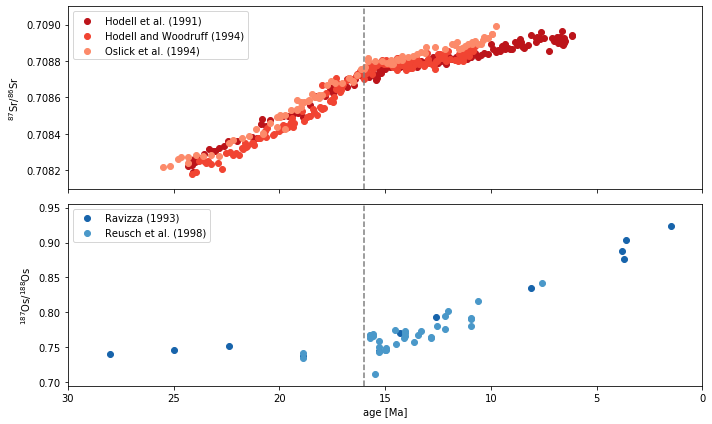

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)

## Myrow et al. (2015)

### Functions

Model from Myrow et al. (2015):

$$
\frac{dR_{SW}}{dt} = \frac{1}{\tau} \sum_{i} \frac{F_{i}}{F_{tot}}(R_{i} - R_{SW})
$$

In [5]:
def calculate_R(X_F_array, X_R_array, X_R_initial, X_n_t, X_t_step, X_tau):
    """
    Perform the seawater model calculations for element X.
    
    Parameters
    ----------
    X_F_array : array with shape (X_n_t, i)
        Fluxes (mol/yr) - each row represents a time slice, and each column represents a source.
        
    X_R_array : array with shape (X_n_t, i)
        Isotope composition - each row represents a time slice, and each column represents a source.
        
    X_R_initial : float
        Initial isotope composition.
        
    X_n_t : int
        Number of model time steps.
        
    X_t_step : float
        Number of years between model time steps.
        
    X_tau : float
        Residence time of element X (yrs).
        
    Returns
    -------
    X_R_SW : array with shape (X_n_t,)
        Isotope composition of seawater.
    """
    X_R_SW = np.zeros(X_n_t)
    X_R_SW[0] = X_R_initial
    
    for i in range(1, X_n_t):
        X_F_total = np.sum(X_F_array[i,:])
        X_R_sum = np.sum((X_F_array[i,:]/X_F_total) * (X_R_array[i,:] - X_R_SW[i-1]))
        d_X_R = (X_R_sum / X_tau) * X_t_step
        X_R_SW[i] = X_R_SW[i-1] + d_X_R
        
    return X_R_SW

### Scenario 1

First, reproduce results from Myrow et al. (2015).

Osmium notes:

* Residence time for osmium is from Oxburgh (2001), which estimated a value of 8-10 kyrs.
* Values for invariant sources are taken straight from Myrow et al. (2015)
* Values for the Himalayas are taken straight from Myrow et al. (2015)

In [6]:
# model time : yrs
Os_t_step = 0.01e6
Os_t = np.arange(28e6, 11e6-Os_t_step, -Os_t_step)
Os_n_t = len(Os_t)

# residence time : yrs
Os_tau = 9000

# F : mol/yr
# R : 187Os/188Os

###################
# invariant sources
Os_F_HT_hydrothermal = np.ones(Os_n_t) * 10.5
Os_R_HT_hydrothermal = np.ones(Os_n_t) * 0.26

Os_F_LT_hydrothermal = np.ones(Os_n_t) * 105.1
Os_R_LT_hydrothermal = np.ones(Os_n_t) * 0.11

Os_F_cosmic = np.ones(Os_n_t) * 52.6
Os_R_cosmic = np.ones(Os_n_t) * 0.127

Os_F_eolian = np.ones(Os_n_t) * 36.8
Os_R_eolian = np.ones(Os_n_t) * 1.05

Os_F_rivers = np.ones(Os_n_t) * 1577
Os_R_rivers = np.ones(Os_n_t) * 0.7934
###################

###################
# Himalayan source
Os_amu = 190.23

# F : 28-16 Ma
Os_F_Himalayas_A = np.zeros(len(Os_t[Os_t>16e6]))

# F : 16-11 Ma
Os_F_Himalayas_B_rate = (1.95e-6 * 1000 / Os_amu) * Os_t_step
Os_F_Himalayas_B = np.linspace(0,
                               Os_F_Himalayas_B_rate*(len(Os_t[Os_t<=16e6])-1),
                               len(Os_t[Os_t<=16e6]))

Os_F_Himalayas = np.concatenate([Os_F_Himalayas_A, Os_F_Himalayas_B])

# R : 28-11 Ma
Os_R_Himalayas = np.ones(Os_n_t) * 3.0
###################

# merge into array
Os_sources = ['HT hydrothermal',
              'LT hydrothermal',
              'cosmic',
              'eolian',
              'rivers',
              'Himalayas']
OS_n_sources = len(Os_sources)
Os_F_array = np.stack([Os_F_HT_hydrothermal,
                       Os_F_LT_hydrothermal,
                       Os_F_cosmic,
                       Os_F_eolian,
                       Os_F_rivers,
                       Os_F_Himalayas], axis=1)
Os_R_array = np.stack([Os_R_HT_hydrothermal,
                       Os_R_LT_hydrothermal,
                       Os_R_cosmic,
                       Os_R_eolian,
                       Os_R_rivers,
                       Os_R_Himalayas], axis=1)

# calculate 187Os/188Os evolution
Os_R_SW = calculate_R(Os_F_array, Os_R_array, 0.7356, Os_n_t, Os_t_step, Os_tau)

Strontium notes:

* Residence time for strontium is from Myrow et al. (2015), which estimated a 2-4 million years.
* Values for invariant sources are taken straight from Myrow et al. (2015)
* Values for the Himalayas are taken straight from Myrow et al. (2015)

In [7]:
# model time : yrs
Sr_t_step = 0.01e6
Sr_t = np.arange(23e6, 10e6-Sr_t_step, -Sr_t_step)
Sr_n_t = len(Sr_t)

# residence time : yrs
Sr_tau = 3e6

# F : mol/yr
# R : 87Sr/86Sr

###################
# invariant sources
Sr_F_diagenetic = np.ones(Sr_n_t) * 3.4e9
Sr_R_diagenetic = np.ones(Sr_n_t) * 0.708

Sr_F_hydrothermal = np.ones(Sr_n_t) * 8.4e9
Sr_R_hydrothermal = np.ones(Sr_n_t) * 0.7025

Sr_F_rivers = np.ones(Sr_n_t) * 31e9
Sr_R_rivers = np.ones(Sr_n_t) * 0.7103
###################

###################
# varying source
Sr_amu = 87.62

# F : 23-16 Ma
Sr_F_Himalayas_A_rate = 1.3e-7 * 1e9 * Sr_t_step
Sr_F_Himalayas_A = np.linspace(0.01e9,
                               0.01e9+Sr_F_Himalayas_A_rate*(len(Sr_t[Sr_t>16e6])-1),
                               len(Sr_t[Sr_t>16e6]))

# F : 16-10 Ma
Sr_F_Himalayas_B_rate = 1.1e-7 * 1e9 * Sr_t_step
Sr_F_Himalayas_B = np.linspace(Sr_F_Himalayas_A[-1],
                               Sr_F_Himalayas_A[-1]+Sr_F_Himalayas_B_rate*(len(Sr_t[Sr_t<=16e6])-1),
                               len(Sr_t[Sr_t<=16e6]))

Sr_F_Himalayas = np.concatenate([Sr_F_Himalayas_A, Sr_F_Himalayas_B])

# R: 23-16 Ma
Sr_R_Himalayas_A_rate = 1.2e-9 * Sr_t_step
Sr_R_Himalayas_A = np.linspace(0.715,
                               0.715+Sr_R_Himalayas_A_rate*(len(Sr_t[Sr_t>16e6])-1),
                               len(Sr_t[Sr_t>16e6]))

# R: 16-10 Ma
Sr_R_Himalayas_B_rate = -0.8e-9 * Sr_t_step
Sr_R_Himalayas_B = np.linspace(Sr_R_Himalayas_A[-1],
                               Sr_R_Himalayas_A[-1]+Sr_R_Himalayas_B_rate*(len(Sr_t[Sr_t<=16e6])-1),
                               len(Sr_t[Sr_t<=16e6]))

Sr_R_Himalayas = np.concatenate([Sr_R_Himalayas_A, Sr_R_Himalayas_B])
###################

# merge into array
Sr_sources = ['diagenetic',
              'hydrothermal',
              'rivers',
              'Himalayas']
Sr_n_sources = len(Sr_sources)
Sr_F_array = np.stack([Sr_F_diagenetic,
                       Sr_F_hydrothermal,
                       Sr_F_rivers,
                       Sr_F_Himalayas], axis=1)
Sr_R_array = np.stack([Sr_R_diagenetic,
                       Sr_R_hydrothermal,
                       Sr_R_rivers,
                       Sr_R_Himalayas], axis=1)

# calculate 87Sr/86Sr evolution
Sr_R_SW = calculate_R(Sr_F_array, Sr_R_array, 0.7082, Sr_n_t, Sr_t_step, Sr_tau)

Plot:

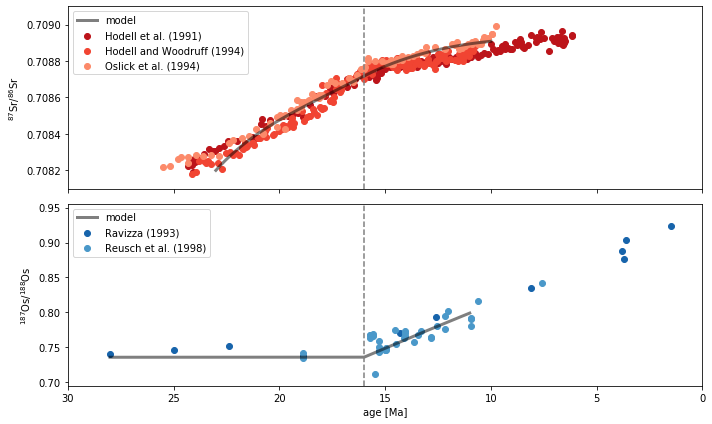

In [8]:
# plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax[0].plot(Sr_t/1e6, Sr_R_SW, c='k', lw=3, alpha=0.5, label='model')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

ax[1].plot(Os_t/1e6, Os_R_SW, c='k', lw=3, alpha=0.5, label='model')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)

### Scenario 2

Rb decay - equations from Vidal (1994), referenced in Goddéris et al. (2017):

In [9]:
def get_MOR_87Sr86Sr(t):
    """
    Get the 87Sr/86Sr for MOR.
    """
    BABI = 0.69897
    lamb = 1.42e-11
    RbSr_mantle = 0.025
    
    r_MOR = BABI + (0.2783*RbSr_mantle*(9.3485+BABI))*(1-np.exp(-lamb * t))
    
    return r_MOR
    
def get_cc_87Sr86Sr(t):
    """
    Get the 87Sr/86Sr for continental crust.
    """
    BABI = 0.69897
    lamb = 1.42e-11
    RbSr_mantle = 0.025
    
    r_cc = BABI + (0.2783*RbSr_mantle*(9.3485+BABI))*(1-np.exp(-lamb*2e9)) +\
                  (0.2783*RbSr_mantle*(9.3485+BABI))*10*(1-np.exp(-lamb*(t-2e9)))
    
    return r_cc

def convert_to_tbp(tsf):
    """
    Convert time since formation (tsf) to time before present (tbp).
    """
    tbp = 4.54e9 - tsf
    return tbp

def convert_to_tsf(tbp):
    """
    Convert tbp to tsf.
    """
    tsf = 4.54e9 - tbp
    return tsf

at 50 Ma, cc  = 0.7252
at 50 Ma, LIP = 0.7033
###
at 0 Ma, cc  = 0.7257
at 0 Ma, LIP = 0.7033


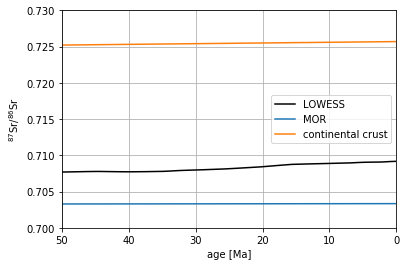

In [10]:
time_evolution = np.linspace(0,4.54e9,500)
MOR_evolution = get_MOR_87Sr86Sr(time_evolution)
cc_evolution = get_cc_87Sr86Sr(time_evolution)

# print some numbers
print('at 50 Ma, cc  = {:.4f}'.format(get_cc_87Sr86Sr(convert_to_tsf(50e6))))
print('at 50 Ma, LIP = {:.4f}'.format(get_MOR_87Sr86Sr(convert_to_tsf(50e6))))
print('###')
print('at 0 Ma, cc  = {:.4f}'.format(get_cc_87Sr86Sr(convert_to_tsf(0))))
print('at 0 Ma, LIP = {:.4f}'.format(get_MOR_87Sr86Sr(convert_to_tsf(0))))

# convert time to Ma
time_evolution = (time_evolution[::-1])/1e6

fig, ax = plt.subplots()
ax.plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')
ax.plot(time_evolution, MOR_evolution, label='MOR', c='C0')
ax.plot(time_evolution, cc_evolution, label='continental crust', c='C1')
ax.set_xlabel('age [Ma]')
ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.set_xlim(50,0)
ax.set_ylim(0.700,0.7300)
ax.grid()
ax.legend()

plt.show(fig)

$$
\frac{dR_{SW}}{dt} = \frac{1}{\tau} \sum_{i} \frac{F_{i}}{F_{tot}}(R_{i} - R_{SW})
$$

| Material           | $^{87}$Sr/$^{86}$Sr | [Mg] (ppm) | [Ca] (ppm) | [Sr] (ppm) |
| :----------------: | :-----------------: | :--------: | :--------: | :--------: |
| radiogenic         | n/a                 | 12800      | 23750      | 310        |
| juvenile           | 0.7035              | 45500      | 71600      | 465        |
| carbonate          | 0.7080              | 47000      | 302300     | 610        |
| hydrothermal       | 0.7030              | n/a        | n/a        | n/a        |

* Sr fluxes
    * Allègre et al. (2010)
        * radiogenic lithologies = ∼25%
        * juvenile lithologies = ∼30%, 0.7035
        * carbonate = ∼35%, 0.7080
        * hydrothermal = ∼10%, 0.7030

In [11]:
# ppm to mol/kg
conc_MgCa_rad = (12800 / 1e6 / 24.305) + (23750 / 1e6 / 40.078)
conc_Sr_rad = 310 / 1e6 / 87.62
conc_MgCa_juv = (45500 / 1e6 / 24.305) + (71600 / 1e6 / 40.078)
conc_Sr_juv = 465 / 1e6 / 87.62
conc_MgCa_crb = (47000 / 1e6 / 24.305) + (302300 / 1e6 / 40.078)
conc_Sr_crb = 610 / 1e6 / 87.62

In [12]:
# stage start ages : yrs
stage_A = 50e6
stage_B = 38e6
stage_C = 15e6

# model time : yrs
t_step = 0.01e6
t = np.arange(stage_A, 0-t_step, -t_step)
n_t = len(t)
n_t_A = len(t[(t>stage_B)])
n_t_B = len(t[(t<=stage_B)&(t>stage_C)])
n_t_C = len(t[(t<=stage_C)])

# residence time : yrs
Sr_tau = 3e6

# F : mol/yr
# R : 87Sr/86Sr

R_Sr_rad = get_cc_87Sr86Sr(convert_to_tsf(t))
R_Sr_juv = np.linspace(0.7035, 0.7035, n_t)
R_Sr_crb = np.linspace(0.7080, 0.7080, n_t)
R_Sr_hyd = np.linspace(0.7030, 0.7030, n_t)

###################

F_Sr_rad_A = np.linspace(0.20, 0.20, n_t_A)
F_Sr_juv_A = np.linspace(0.35, 0.35, n_t_A)
F_Sr_crb_A = np.linspace(0.35, 0.35, n_t_A)
F_Sr_hyd_A = np.linspace(0.10, 0.10, n_t_A)

F_W_rad_A = F_Sr_rad_A / conc_Sr_rad
F_MgCa_rad_A = F_W_rad_A * conc_MgCa_rad

F_W_juv_A = F_Sr_juv_A / conc_Sr_juv
F_MgCa_juv_A = F_W_juv_A * conc_MgCa_juv

###################

F_Sr_rad_B = np.linspace(0.20, 0.20, n_t_B)
F_Sr_juv_B = np.linspace(0.35, 0.35, n_t_B)
F_Sr_crb_B = np.linspace(0.35, 0.35, n_t_B)
F_Sr_hyd_B = np.linspace(0.10, 0.10, n_t_B)

F_W_rad_B = F_Sr_rad_B / conc_Sr_rad
F_MgCa_rad_B = F_W_rad_B * conc_MgCa_rad

F_W_juv_B = F_Sr_juv_B / conc_Sr_juv
F_MgCa_juv_B = F_W_juv_B * conc_MgCa_juv

###################

F_Sr_rad_C = np.linspace(0.20, 0.20, n_t_C)
F_Sr_juv_C = np.linspace(0.35, 0.35, n_t_C)
F_Sr_crb_C = np.linspace(0.35, 0.35, n_t_C)
F_Sr_hyd_C = np.linspace(0.10, 0.10, n_t_C)

F_W_rad_C = F_Sr_rad_C / conc_Sr_rad
F_MgCa_rad_C = F_W_rad_C * conc_MgCa_rad

F_W_juv_C = F_Sr_juv_C / conc_Sr_juv
F_MgCa_juv_C = F_W_juv_C * conc_MgCa_juv

###################

F_Sr_rad = np.concatenate([F_Sr_rad_A, F_Sr_rad_B, F_Sr_rad_C])
F_Sr_juv = np.concatenate([F_Sr_juv_A, F_Sr_juv_B, F_Sr_juv_C])
F_Sr_crb = np.concatenate([F_Sr_crb_A, F_Sr_crb_B, F_Sr_crb_C])
F_Sr_hyd = np.concatenate([F_Sr_hyd_A, F_Sr_hyd_B, F_Sr_hyd_C])

# merge into array
Sr_sources = ['radiogenic',
              'juvenile',
              'carbonate',
              'hydrothermal']
Sr_n_sources = len(Sr_sources)
F_Sr_array = np.stack([F_Sr_rad,
                       F_Sr_juv,
                       F_Sr_crb,
                       F_Sr_hyd], axis=1)
R_Sr_array = np.stack([R_Sr_rad,
                       R_Sr_juv,
                       R_Sr_crb,
                       R_Sr_hyd], axis=1)

# calculate 87Sr/86Sr evolution
R_Sr_SW = calculate_R(F_Sr_array, R_Sr_array, 0.7077, n_t, t_step, Sr_tau)

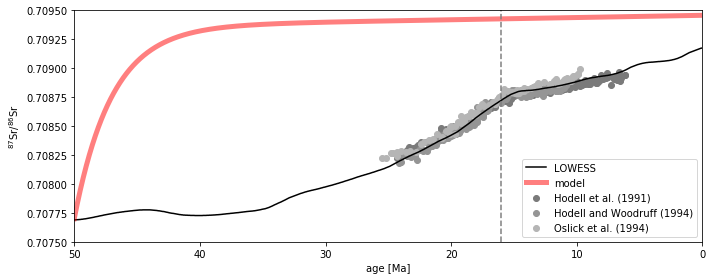

In [13]:
# plot
fig, ax = plt.subplots(figsize=(10,4))

# Sr
Sr_cmap = get_cmap('Greys')

ax.scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.6)], label='Hodell et al. (1991)')
ax.scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.5)], label='Hodell and Woodruff (1994)')
ax.scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax.plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')

ax.plot(t/1e6, R_Sr_SW, c='red', lw=5, alpha=0.5, label='model')

# prettify
ax.axvline(16, ls='--', c='C7')

ax.set_xlim(50,0)
ax.set_ylim(0.7075,0.7095)
ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.legend()
ax.set_xlabel('age [Ma]')

fig.tight_layout()
plt.show(fig)

## Park et al. (2020)

### Functions

Other helper functions:

In [14]:
def dict_to_sorted_df(dictionary):
    """
    Convert a dictionary to a sorted pandas df.

    Parameters
    ----------
    dictionary : dictionary

    Returns
    -------
    df : sorted pandas dataframe
    """
    df = pd.DataFrame(list(dictionary.items()), columns=['var','val'])
    df.sort_values('var',inplace=True)
    df.reset_index(inplace=True,drop=True)

    return df

def plot_seawater_model(t, Mg, Ca, Sr88, Sr87, Sr86, min8786, max8786, minMgCa, maxMgCa, mint, maxt):
    """
    Plot the results of the seawater model.
    
    dt : float
        time step, in years
    T : float
        model duration, in years
    t : numpy array
        containing the time
    Mg : numpy array
        containing Mg abundance in mols
    Ca : numpy array
        containing Ca abundance in mols
    Sr88 : numpy array
        containing Sr88 abundance in mols
    Sr87 : numpy array
        containing Sr87 abundance in mols
    Sr86 : numpy array
        containing Sr86 abundance in mols
    t_start : float
        the time (in ybp) of storage vector start
    ind_vars_i : pandas dataframe
        of independent variables at the start of the model
    ind_vars_f : pandas dataframe
        of independent variables at the end of the model

    Parameters
    ----------
    t : numpy array
        containing the time
    Mg : numpy array
        containing Mg abundance in mols
    Ca : numpy array
        containing Ca abundance in mols
    Sr88 : numpy array
        containing Sr88 abundance in mols
    Sr87 : numpy array
        containing Sr87 abundance in mols
    Sr86 : numpy array
        containing Sr86 abundance in mols
    min8786 : float
        minimum y-value to be used in the 87Sr/86Sr plot
    max8786 : float
        maximum y-value to be used in the 87Sr/86Sr plot
    minMgCa : float
        minimum y-value to be used in the Mg/Ca plot
    maxMgCa : float
        maximum y-value to be used in the Mg/Ca plot
    mint : float
        minimum time to plot
    maxt : float
        maximum time to plot

    Returns
    -------
    fig : figure handle of output plot
    ax : axes handles of output plot
    """
    fig, ax = plt.subplots(nrows=4,ncols=2,sharex=True,figsize=(10,10))
    ax[0,0].plot(t,Mg)
    ax[0,0].set_title('Mg')
    ax[0,0].set_ylabel('[mol]')
    ax[0,1].plot(t,Ca)
    ax[0,1].set_title('Ca')
    ax[0,1].set_ylabel('[mol]')
    ax[1,0].plot(t,Sr86)
    ax[1,0].set_title('$^{86}$Sr')
    ax[1,0].set_ylabel('[mol]')
    ax[1,1].plot(t,Sr87)
    ax[1,1].set_title('$^{87}$Sr')
    ax[1,1].set_ylabel('[mol]')
    ax[2,0].plot(t,Sr88)
    ax[2,0].set_title('$^{88}$Sr')
    ax[2,0].set_ylabel('[mol]')
    ax[2,1].plot(t,Sr88+Sr87+Sr86)
    ax[2,1].set_title('Sr')
    ax[2,1].set_ylabel('[mol]')
    ax[3,0].plot(t,Sr87/Sr86,color='C1',lw=3)
    ax[3,0].set_title('$^{87}$Sr/$^{86}$Sr')
    ax[3,0].set_xlabel('model duration [yrs]')
    ax[3,0].set_ylim(min8786,max8786)
    ax[3,1].plot(t,Mg/Ca,color='C1',lw=3)
    ax[3,1].set_title('Mg/Ca')
    ax[3,1].set_xlabel('model duration [yrs]')
    ax[3,1].set_ylim(minMgCa,maxMgCa)
    ax[3,1].set_xlim(mint,maxt)
    plt.show(fig)
    return fig, ax

### Scenario 1

#### Functions

Seawater model equations:

(1) $\frac{dMg}{dt} = W_{Mg-carb} + W_{Mg-cc} + W_{Mg-juv} - H_{Mg-clays} - P_{Mg-carb}$

(2) $\frac{dCa}{dt} = W_{Ca-carb} + W_{Ca-cc} + W_{Ca-juv} + H_{Ca-basalt} - P_{Ca-carb}$

(3) $\frac{d^{n}Sr}{dt} = W_{^{n}Sr-carb} + W_{^{n}Sr-cc} + W_{^{n}Sr-juv} + H_{^{n}Sr-basalt} - P_{^{n}Sr-carb}$

where $W_{X-carb} = W_{X-carb1} + W_{X-carb2}$

In [15]:
def seawater_model(dt, T, t, Mg, Ca, Sr88, Sr87, Sr86, t_start, ind_vars_i, ind_vars_f):
    """
    Perform the seawater model.
    
    Parameters
    ----------
    dt : float
        time step, in years
    T : float
        model duration, in years
    t : numpy array
        containing the time
    Mg : numpy array
        containing Mg abundance in mols
    Ca : numpy array
        containing Ca abundance in mols
    Sr88 : numpy array
        containing Sr88 abundance in mols
    Sr87 : numpy array
        containing Sr87 abundance in mols
    Sr86 : numpy array
        containing Sr86 abundance in mols
    t_start : float
        the time (in ybp) of storage vector start
    ind_vars_i : pandas dataframe
        of independent variables at the start of the model
    ind_vars_f : pandas dataframe
        of independent variables at the end of the model
    
    Returns
    -------
    (t,Mg,Ca,Sr88,Sr87,Sr86) = tuple with corresponding numpy arrays
    """
    # length of input vectors
    L = len(t)
    
    # the number of timesteps
    n = int(T / dt)
    
    # create numpy array for each of the independent variables - linearly spaced
    ind_vars = {}
    for i in range(len(ind_vars_i.index)):
        ind_vars[ind_vars_i['var'][i]] = np.linspace(ind_vars_i['val'][i], ind_vars_f['val'][i], n)
        # notify user if variable is evolving
        if ind_vars_i['val'][i] - ind_vars_f['val'][i] != 0:
            print(ind_vars_i['var'][i] + ' changing from ' +\
                  str(ind_vars_i['val'][i]) + ' to ' + str(ind_vars_f['val'][i]))

    # execute model in for loop
    for i in range(L, L+n):
        # bulk weathering flux
        W_X_carb1 = ind_vars['W_X_carb1'][i-L]
        W_X_carb2 = ind_vars['W_X_carb2'][i-L]
        W_X_carb = W_X_carb1 + W_X_carb2
        W_X_cc = ind_vars['W_X_cc'][i-L]
        W_X_juv = ind_vars['W_X_juv'][i-L]
        
        # Mg
        W_Mg_carb1 = W_X_carb1*ind_vars['conc_Mg_carb1'][i-L]
        W_Mg_carb2 = W_X_carb2*ind_vars['conc_Mg_carb2'][i-L]
        W_Mg_carb = W_Mg_carb1 + W_Mg_carb2
        W_Mg_cc = W_X_cc*ind_vars['conc_Mg_cc'][i-L]
        W_Mg_juv = W_X_juv*ind_vars['conc_Mg_juv'][i-L]
        H_Mg_clays = ind_vars['k'][i-L]*(Mg[i-1]/ind_vars['Msw'][i-L])
        dMg = (W_Mg_carb + W_Mg_cc + W_Mg_juv - H_Mg_clays - ind_vars['P_Mg_carb'][i-L]) * dt
    
        # Ca
        W_Ca_carb1 = W_X_carb1*ind_vars['conc_Ca_carb1'][i-L]
        W_Ca_carb2 = W_X_carb2*ind_vars['conc_Ca_carb2'][i-L]
        W_Ca_carb = W_Ca_carb1 + W_Ca_carb2
        W_Ca_cc = W_X_cc*ind_vars['conc_Ca_cc'][i-L]
        W_Ca_juv = W_X_juv*ind_vars['conc_Ca_juv'][i-L]
        H_Ca_basalt = H_Mg_clays / ind_vars['alpha_MgCa'][i-L]
        P_Ca_carb = W_Mg_carb+W_Mg_cc+W_Mg_juv-ind_vars['P_Mg_carb'][i-L]+W_Ca_carb+W_Ca_cc+W_Ca_juv
        dCa = (W_Ca_carb + W_Ca_cc + W_Ca_juv + H_Ca_basalt - P_Ca_carb) * dt
    
        # total Sr
        W_Sr_carb1 = W_X_carb1*ind_vars['conc_Sr_carb1'][i-L]
        W_Sr_carb2 = W_X_carb2*ind_vars['conc_Sr_carb2'][i-L]
        W_Sr_carb = W_Sr_carb1 + W_Sr_carb2
        W_Sr_cc = W_X_cc*ind_vars['conc_Sr_cc'][i-L]
        W_Sr_juv = W_X_juv*ind_vars['conc_Sr_juv'][i-L]
        H_Sr_basalt = ind_vars['alpha_SrCa'][i-L]*H_Ca_basalt
        P_Sr_carb = ((Sr88[i-1]+Sr87[i-1]+Sr86[i-1])/Ca[i-1])*ind_vars['K_Sr'][i-L]*P_Ca_carb
        
        # precipitating carbonate matches seawater chemistry
        P_87Sr86Sr_carb = Sr87[i-1]/Sr86[i-1]
        
        # W_87Sr86Sr_cc
        W_87Sr86Sr_cc = get_cc_87Sr86Sr(convert_to_tsf(t_start - t[i-1]))
    
        # get 86Sr first
        W_86Sr_carb1 = W_Sr_carb1/((1/ind_vars['r_86Sr88Sr'][i-L])+ind_vars['W_87Sr86Sr_carb1'][i-L]+1)
        W_86Sr_carb2 = W_Sr_carb2/((1/ind_vars['r_86Sr88Sr'][i-L])+ind_vars['W_87Sr86Sr_carb2'][i-L]+1)
        W_86Sr_carb = W_86Sr_carb1 + W_86Sr_carb2
        W_86Sr_cc = W_Sr_cc/((1/ind_vars['r_86Sr88Sr'][i-L])+W_87Sr86Sr_cc+1)
        W_86Sr_juv = W_Sr_juv/((1/ind_vars['r_86Sr88Sr'][i-L])+ind_vars['W_87Sr86Sr_juv'][i-L]+1)
        H_86Sr_basalt = H_Sr_basalt/((1/ind_vars['r_86Sr88Sr'][i-L])+ind_vars['H_87Sr86Sr_basalt'][i-L]+1)
        P_86Sr_carb = P_Sr_carb/((1/ind_vars['r_86Sr88Sr'][i-L])+P_87Sr86Sr_carb+1)
        dSr86 = (W_86Sr_carb + W_86Sr_cc + W_86Sr_juv + H_86Sr_basalt - P_86Sr_carb) * dt
    
        # use 86Sr to get 88Sr
        dSr88 = dSr86/ind_vars['r_86Sr88Sr'][i-L]
    
        # get 87Sr
        W_87Sr_carb1 = W_86Sr_carb1*ind_vars['W_87Sr86Sr_carb1'][i-L]
        W_87Sr_carb2 = W_86Sr_carb2*ind_vars['W_87Sr86Sr_carb2'][i-L]
        W_87Sr_carb = W_87Sr_carb1 + W_87Sr_carb2
        W_87Sr_cc = W_86Sr_cc*W_87Sr86Sr_cc
        W_87Sr_juv = W_86Sr_juv*ind_vars['W_87Sr86Sr_juv'][i-L]
        H_87Sr_basalt = H_86Sr_basalt*ind_vars['H_87Sr86Sr_basalt'][i-L]
        P_87Sr_carb = P_86Sr_carb * P_87Sr86Sr_carb
        dSr87 = (W_87Sr_carb + W_87Sr_cc + W_87Sr_juv + H_87Sr_basalt - P_87Sr_carb) * dt
    
        # store results
        Mg = np.append(Mg, Mg[i-1]+dMg)
        Ca = np.append(Ca, Ca[i-1]+dCa)
        Sr86 = np.append(Sr86, Sr86[i-1]+dSr86)
        Sr88 = np.append(Sr88, Sr88[i-1]+dSr88)
        Sr87 = np.append(Sr87, Sr87[i-1]+dSr87)
        t = np.append(t, t[i-1]+dt)
    
    return (t,Mg,Ca,Sr88,Sr87,Sr86)

A function to pre-determine the initial steady state Mg/Ca (for any given set of independent variables):

In [16]:
def get_initial_Mg_Ca(r_MgCa, ind_vars):
    """
    Calculate initial Mg and Ca that will produce desired Mg/Ca at steady state.
    
    Parameters
    ----------
    r_MgCa : float
        desired Mg/Ca at steady state after initial spin up
    ind_vars : dictionary
        of independent variables at the start of the model

    Returns
    -------
    Mg_0 : float
        initial Mg composition
    Ca_0 :float
        initial Ca composition
    """
    # Mg fluxes
    W_Mg_carb1 = ind_vars['W_X_carb1']*ind_vars['conc_Mg_carb1']
    W_Mg_carb2 = ind_vars['W_X_carb2']*ind_vars['conc_Mg_carb2']
    W_Mg_carb = W_Mg_carb1 + W_Mg_carb2
    W_Mg_cc = ind_vars['W_X_cc']*ind_vars['conc_Mg_cc']
    W_Mg_juv = ind_vars['W_X_juv']*ind_vars['conc_Mg_juv']
    
    # make the initial Mg the steady state value
    Mg_0 = ((W_Mg_carb + W_Mg_cc + W_Mg_juv - ind_vars['P_Mg_carb']) / ind_vars['k']) * ind_vars['Msw']
    
    # since we are starting Mg at the steady state value, we can simply set the initial Ca to be at the desired ratio
    Ca_0 = Mg_0 / r_MgCa
    
    return (Mg_0, Ca_0)

A function to pre-determine the initial steady state $^{87}$Sr/$^{86}$Sr by fixing the exposed area of carbonate, and varying the ratio of exposed continental crust to juveniles:

In [17]:
def get_initial_parameters(r_MgCa, r_87Sr86Sr, Sr_0,
                           W_X_carb1, W_X_carb2, W_X_juv, W_X_cc_min, W_X_cc_max,
                           t_start, ind_vars, n):
    """
    Calculate initial parameters that will produce desired Mg/Ca and 87Sr/86Sr ratios at steady state.
    
    Parameters
    ----------
    r_MgCa : float
        desired Mg/Ca at steady state after initial spin up
    r_87Sr86Sr : float
        desired 87Sr/86Sr at steady state after initial spin up
    Sr_0 : float
        initial Sr
    W_X_carb1 : float
        in kg/yr
    W_X_carb2 : float
        in kg/yr
    W_X_juv : float
        in kg/yr
    W_X_cc_min : float
        minimum W_X_cc to test in kg/yr
    W_X_cc_max : float
        maximum W_X_cc to test in kg/yr
    t_start : float
        the time (in ybp) of storage vector start
    ind_vars : dictionary
        of independent variables to vary
    n : int
        number of times to run the loop
    
    Returns
    -------
    (Mg_0, Ca_0, W_X_cc) = tuple with initial Mg, Ca, W_X_cc
    """
    dt = 0.1e6
    T = 500e6 #assume we will be in steady state by 500e6 yrs
    Sr88_0 = 0.82 * Sr_0 #approximate ratios
    Sr87_0 = 0.073 * Sr_0
    Sr86_0 = 0.107 * Sr_0
    
    # ratios to test
    W_X_ccs = np.linspace(W_X_cc_min, W_X_cc_max, n)
    
    # storage vectors
    Mg_0_vals = np.array([])
    Ca_0_vals = np.array([])
    Sr87Sr86_ss = np.array([])
    
    for i in range(n):
        # change the ratio
        ind_vars_copy = ind_vars.copy()
        ind_vars_copy['W_X_carb1'] = W_X_carb1
        ind_vars_copy['W_X_carb2'] = W_X_carb2
        ind_vars_copy['W_X_cc'] = W_X_ccs[i]
        ind_vars_copy['W_X_juv'] = W_X_juv
        
        # get the initial Mg and Ca that will give the desired Mg/Ca ratio
        (Mg_0_temp, Ca_0_temp) = get_initial_Mg_Ca(r_MgCa, ind_vars_copy)
        Mg_0_vals = np.append(Mg_0_vals, Mg_0_temp)
        Ca_0_vals = np.append(Ca_0_vals, Ca_0_temp)
        
        # convert dictionary to dataframe
        ind_vars_copy_df = dict_to_sorted_df(ind_vars_copy)
        
        # use this initial Ca to determine what the steady state 87Sr/86Sr is
        t = np.array([0])
        Mg = np.array([Mg_0_temp])
        Ca = np.array([Ca_0_temp])
        Sr88 = np.array([Sr88_0])
        Sr87 = np.array([Sr87_0])
        Sr86 = np.array([Sr86_0])
        (t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model(dt,T,t,Mg,Ca,Sr88,Sr87,Sr86,
                                                  t_start,ind_vars_copy_df,ind_vars_copy_df)
        Sr87Sr86_ss = np.append(Sr87Sr86_ss, (Sr87[-1]/Sr86[-1]))

    # find the values that give the closest match to the desired 87Sr/86Sr at steady state
    diff = np.array([])
    for i in range(n):
        diff = np.append(diff, abs(Sr87Sr86_ss[i] - r_87Sr86Sr))
    min_ind = diff.argmin()
    Mg_0 = Mg_0_vals[min_ind]
    Ca_0 = Ca_0_vals[min_ind]
    W_X_cc = W_X_ccs[min_ind]
    
    # calculate Sr fluxes
    W_Sr_cc = W_X_cc*ind_vars['conc_Sr_cc']
    W_Sr_juv = W_X_juv*ind_vars['conc_Sr_juv']
    W_Sr_carb1 = W_X_carb1*ind_vars['conc_Sr_carb1']
    W_Sr_carb2 = W_X_carb2*ind_vars['conc_Sr_carb2']
    W_Sr_carb = W_Sr_carb1 + W_Sr_carb2
    H_Sr_basalt = ind_vars['alpha_SrCa']*((ind_vars['k']*(Mg_0/ind_vars['Msw']))/ind_vars['alpha_MgCa'])
    total_Sr_flux = H_Sr_basalt + W_Sr_carb + W_Sr_cc + W_Sr_juv
    
    # plot
    fig, ax = plt.subplots()
    ax.plot(W_X_ccs,Sr87Sr86_ss, color='b', linewidth=3)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.hlines(r_87Sr86Sr, W_X_cc_min, W_X_cc_max, color='r', linewidth=3, linestyle='--')
    ax.set_xlabel('input W_X_cc')
    ax.set_ylabel('steady state $^{87}$Sr/$^{86}$Sr')
    ax.set_xlim(W_X_cc_min,W_X_cc_max)
    plt.show(fig)
    
    # print the solutions and deviation away from the desired value
    print('Mg_0 =    ' + str(Mg_0))
    print('Ca_0 =    ' + str(Ca_0))
    print('W_X_cc =  ' + str(W_X_cc))
    print('###')
    print('Desired ratio was: ' + str(r_87Sr86Sr))
    print('Obtained ratio is: ' + str(Sr87Sr86_ss[min_ind]))
    print('Difference is:     ' + str(diff[min_ind]))
    print('###')
    print('W_Sr_cc     = {:.2f}%'.format((W_Sr_cc / total_Sr_flux) * 100))
    print('W_Sr_juv    = {:.2f}%'.format((W_Sr_juv / total_Sr_flux) * 100))
    print('W_Sr_carb   = {:.2f}%'.format((W_Sr_carb / total_Sr_flux) * 100))
    print('H_Sr_basalt = {:.2f}%'.format((H_Sr_basalt / total_Sr_flux) * 100))
    
    return (Mg_0, Ca_0, W_X_cc)

Calculate Sr fluxes after the seawater model has completed:

In [18]:
def get_Sr_fluxes(ind_vars_2, ind_vars_3, ind_vars_4, Mg, T_ss, T_stage1, T_stage2, dt):
    """
    Calculate Sr fluxes after the seawater model has completed.
    
    Parameters
    ----------
    ind_vars_2 : dictionary
        of independent variables at steady state
    ind_vars_3 : dictionary
        of independent variables to at stage 1 end
    ind_vars_4 : dictionary
        of independent variables to at stage 2 end
    Mg : numpy array
        containing Mg abundance in mols
    T_ss : float
        steady state model duration, in years
    T_stage1 : float
        stage 1 model duration, in years
    T_stage2 : float
        stage 2 model duration, in years
    dt : float
        time step, in years
    
    Returns
    -------
    W_Sr_cc, W_Sr_juv, W_Sr_carb, H_Sr_basalt, k
    """
    # initialize
    W_Sr_cc = np.array([ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc']])
    W_Sr_juv = np.array([ind_vars_2['W_X_juv']*ind_vars_2['conc_Sr_juv']])
    W_Sr_carb1 = np.array([ind_vars_2['W_X_carb1']*ind_vars_2['conc_Sr_carb1']])
    W_Sr_carb2 = np.array([ind_vars_2['W_X_carb2']*ind_vars_2['conc_Sr_carb2']])
    k = np.array([ind_vars_2['k']])
    
    # steady state
    W_Sr_cc = np.concatenate((W_Sr_cc,\
                              np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                                          ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                                          int(T_ss/dt))))
    W_Sr_juv = np.concatenate((W_Sr_juv,\
                               np.linspace(ind_vars_2['W_X_juv']*ind_vars_2['conc_Sr_juv'],\
                                           ind_vars_2['W_X_juv']*ind_vars_2['conc_Sr_juv'],\
                                           int(T_ss/dt))))
    W_Sr_carb1 = np.concatenate((W_Sr_carb1,\
                                 np.linspace(ind_vars_2['W_X_carb1']*ind_vars_2['conc_Sr_carb1'],\
                                             ind_vars_2['W_X_carb1']*ind_vars_2['conc_Sr_carb1'],\
                                             int(T_ss/dt))))
    W_Sr_carb2 = np.concatenate((W_Sr_carb2,\
                                 np.linspace(ind_vars_2['W_X_carb2']*ind_vars_2['conc_Sr_carb2'],\
                                             ind_vars_2['W_X_carb2']*ind_vars_2['conc_Sr_carb2'],\
                                             int(T_ss/dt))))
    k = np.concatenate((k,\
                        np.linspace(ind_vars_2['k'], ind_vars_2['k'], int(T_ss/dt))))

    # add stage 1
    W_Sr_cc = np.concatenate((W_Sr_cc,\
                              np.linspace(ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc'],\
                                          ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                          int(T_stage1/dt))))
    W_Sr_juv = np.concatenate((W_Sr_juv,\
                               np.linspace(ind_vars_2['W_X_juv']*ind_vars_2['conc_Sr_juv'],\
                                           ind_vars_3['W_X_juv']*ind_vars_3['conc_Sr_juv'],\
                                           int(T_stage1/dt))))
    W_Sr_carb1 = np.concatenate((W_Sr_carb1,\
                                 np.linspace(ind_vars_2['W_X_carb1']*ind_vars_2['conc_Sr_carb1'],\
                                             ind_vars_3['W_X_carb1']*ind_vars_3['conc_Sr_carb1'],\
                                             int(T_stage1/dt))))
    W_Sr_carb2 = np.concatenate((W_Sr_carb2,\
                                 np.linspace(ind_vars_2['W_X_carb2']*ind_vars_2['conc_Sr_carb2'],\
                                             ind_vars_3['W_X_carb2']*ind_vars_3['conc_Sr_carb2'],\
                                             int(T_stage1/dt))))
    k = np.concatenate((k,\
                        np.linspace(ind_vars_2['k'], ind_vars_3['k'], int(T_stage1/dt))))

    # add stage 2
    W_Sr_cc = np.concatenate((W_Sr_cc,\
                              np.linspace(ind_vars_3['W_X_cc']*ind_vars_3['conc_Sr_cc'],\
                                          ind_vars_4['W_X_cc']*ind_vars_4['conc_Sr_cc'],\
                                          int(T_stage2/dt))))
    W_Sr_juv = np.concatenate((W_Sr_juv,\
                               np.linspace(ind_vars_3['W_X_juv']*ind_vars_3['conc_Sr_juv'],\
                                           ind_vars_4['W_X_juv']*ind_vars_4['conc_Sr_juv'],\
                                           int(T_stage2/dt))))
    W_Sr_carb1 = np.concatenate((W_Sr_carb1,\
                                 np.linspace(ind_vars_3['W_X_carb1']*ind_vars_3['conc_Sr_carb1'],\
                                             ind_vars_4['W_X_carb1']*ind_vars_4['conc_Sr_carb1'],\
                                             int(T_stage2/dt))))
    W_Sr_carb2 = np.concatenate((W_Sr_carb2,\
                                 np.linspace(ind_vars_3['W_X_carb2']*ind_vars_3['conc_Sr_carb2'],\
                                             ind_vars_4['W_X_carb2']*ind_vars_4['conc_Sr_carb2'],\
                                             int(T_stage2/dt))))
    k = np.concatenate((k,\
                        np.linspace(ind_vars_3['k'], ind_vars_4['k'], int(T_stage2/dt))))

    # H_Sr_basalt - assuming alpha_SrCa, Msw, alpha_MgCa are invariant
    H_Sr_basalt = ind_vars_2['alpha_SrCa']*((k*(Mg/ind_vars_2['Msw']))/ind_vars_2['alpha_MgCa'])
    
    return (W_Sr_cc, W_Sr_juv, W_Sr_carb1, W_Sr_carb2, H_Sr_basalt, k)

#### Set Up

The material values that we will use:
    
| Material           | $^{87}$Sr/$^{86}$Sr | [Mg] (ppm) | [Ca] (ppm) | [Sr] (ppm) |
| :----------------: | :-----------------: | :--------: | :--------: | :--------: |
| continental crust  | n/a                 | 12800      | 23750      | 310        |
| juvenile           | 0.7035              | 45500      | 71600      | 465        |
| carbonate          | 0.7080              | 47000      | 302300     | 610        |
| hydrothermal       | 0.7030              | n/a        | n/a        | n/a        |

* Mg/Ca
    * Higgins and Schrag (2012)
        * ~40-15 Ma : Mg/Ca = ~1.5-2
        * ~15-0 Ma : Mg/Ca increases roughly linearly to 5
        
* seawater Mg and Ca concentrations
    * Higgins and Schrag (2012)
        * ~40-15 Ma : Mg = ~36 mM, Ca = ~18-24 mM
        * ~15-0 Ma : Mg and Ca increase roughly linearly to ~50 and ~10 mM respectively

* $^{87}$Sr/$^{86}$Sr
    * Hodell et al. (1991), Hodell and Woodruff (1994), Oslick et al. (1994)
        * ~0.7082 at 24 Ma
    * LOWESS (unknown source)
        * ~0.7077 at 35 Ma
        
* Sr fluxes
    * Allègre et al. (2010)
        * radiogenic lithologies = ∼25%
        * juvenile lithologies = ∼30%, 0.7035
        * carbonate = ∼35%, 0.7080
        * hydrothermal = ∼10%, 0.7030
        
* seawater Sr concentration
    * de Villiers (1999)
        * 87.40 $\mu$M
        
* flux of water in hydrothermal systems
    * Elderfield and Schultz (1996)
        * 3 ± 1.5 $\times$ 10$^{13}$ kg(H$_{2}$O)/yr
        
* seawater Sr residence time
    * Veizer (1989)
        * ~3-5 m.y.
        
* Sr distribution coefficient in carbonate ($K_{Sr}$)
    * Mucci and Morse (1983)
        * 0.15-0.35

In [19]:
ind_vars_1 = {'W_X_carb1':7.5e14,                     #kg/yr
              'W_X_carb2':0.0,                     #kg/yr
              'W_X_cc':8.0e14,                       #kg/yr - this value gets set during spin up
              'W_X_juv':10.0e14,                      #kg/yr
              'conc_Mg_cc':12800 / 1e6 / 24.305,    #ppm to mol/kg
              'conc_Ca_cc':23750 / 1e6 / 40.078,    #ppm to mol/kg
              'conc_Sr_cc':310 / 1e6 / 87.62,       #ppm to mol/kg
              'conc_Mg_juv':45500 / 1e6 / 24.305,   #ppm to mol/kg
              'conc_Ca_juv':71600 / 1e6 / 40.078,   #ppm to mol/kg
              'conc_Sr_juv':465 / 1e6 / 87.62,      #ppm to mol/kg
              'conc_Mg_carb1':47000 / 1e6 / 24.305,  #ppm to mol/kg
              'conc_Ca_carb1':302300 / 1e6 / 40.078, #ppm to mol/kg
              'conc_Sr_carb1':610 / 1e6 / 87.62,     #ppm to mol/kg
              'conc_Mg_carb2':47000 / 1e6 / 24.305,  #ppm to mol/kg
              'conc_Ca_carb2':302300 / 1e6 / 40.078, #ppm to mol/kg
              'conc_Sr_carb2':610 / 1e6 / 87.62,     #ppm to mol/kg
              'alpha_MgCa':1,
              'alpha_SrCa':0.0010,
              'k':4.5e13,                             #kg(H2O)/yr
              'P_Mg_carb':1.8e12,                      #mol/yr
              'K_Sr':0.85,
              'W_87Sr86Sr_juv':0.7035,
              'W_87Sr86Sr_carb1':0.7080,
              'W_87Sr86Sr_carb2':0.7080,
              'H_87Sr86Sr_basalt':0.7030,
              'r_86Sr88Sr':0.1194,
              'Msw':1.35e21}                           #kg

In [20]:
stage1_age = 38e6
stage2_age = 15e6
t_start = stage1_age + 500e6

Get initial parameters:

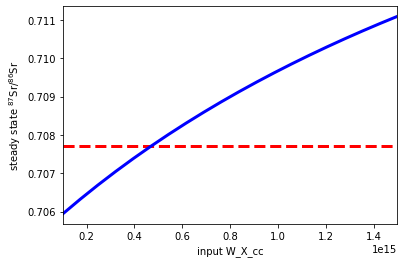

Mg_0 =    5.307153607120043e+19
Ca_0 =    3.5381024047466955e+19
W_X_cc =  468421052631579.0
###
Desired ratio was: 0.7077
Obtained ratio is: 0.7077023255397843
Difference is:     2.3255397842980585e-06
###
W_Sr_cc     = 11.88%
W_Sr_juv    = 38.03%
W_Sr_carb   = 37.42%
H_Sr_basalt = 12.68%


In [21]:
mm_Sr = 87.62 #molar mass of Sr
Sr_0 = 87.40 * 1e-6 * ind_vars_1['Msw']

(Mg_0,Ca_0,W_X_cc) = get_initial_parameters(1.5,0.7077,Sr_0,
                                            ind_vars_1['W_X_carb1'],ind_vars_1['W_X_carb2'],ind_vars_1['W_X_juv'],\
                                            1e14,15e14,t_start,ind_vars_1,20)

* radiogenic lithologies = ∼25%
* juvenile lithologies = ∼30%
* carbonate = ∼35%
* hydrothermal = ∼10%

Use the initial parameters and run to steady state:

In [22]:
dt = 0.1e6
T_ss = 500e6

ind_vars_2 = ind_vars_1.copy()
ind_vars_2['W_X_cc'] = W_X_cc
ind_vars_2_df = dict_to_sorted_df(ind_vars_2)

Sr88_0 = 0.82 * Sr_0 #approximate ratios
Sr87_0 = 0.073 * Sr_0
Sr86_0 = 0.107 * Sr_0

t = np.array([0])
Mg = np.array([Mg_0])
Ca = np.array([Ca_0])
Sr88 = np.array([Sr88_0])
Sr87 = np.array([Sr87_0])
Sr86 = np.array([Sr86_0])

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model(dt,T_ss,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_2_df)

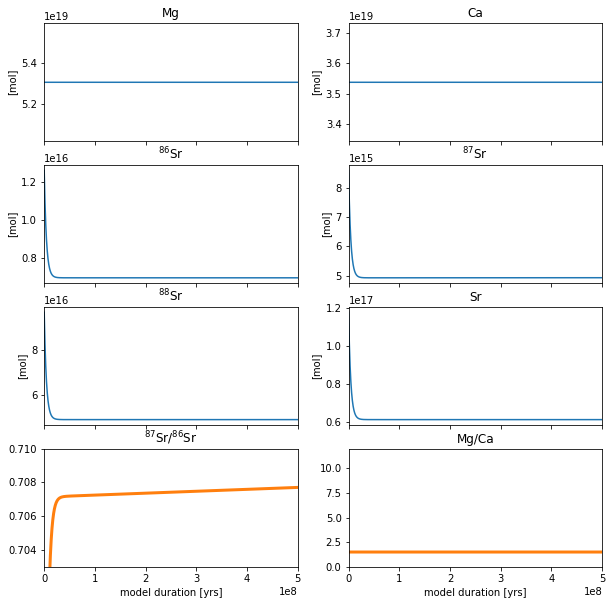

In [23]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss)

Check some characteristics of the model:

In [24]:
# Sr residence time
W_Sr_cc_i = ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc']
W_Sr_juv_i = ind_vars_2['W_X_juv']*ind_vars_2['conc_Sr_juv']
W_Sr_carb1_i = ind_vars_2['W_X_carb1']*ind_vars_2['conc_Sr_carb1']
W_Sr_carb2_i = ind_vars_2['W_X_carb2']*ind_vars_2['conc_Sr_carb2']
W_Sr_carb_i = W_Sr_carb1_i + W_Sr_carb2_i
H_Sr_basalt_i = ind_vars_2['alpha_SrCa']*((ind_vars_2['k']*(Mg[-1]/ind_vars_2['Msw']))/ind_vars_2['alpha_MgCa'])
total_Sr_flux_i = W_Sr_cc_i + W_Sr_juv_i + W_Sr_carb_i + H_Sr_basalt_i

print('Sr residence time = {:.2f} m.y.'.format((Sr88[-1]+Sr87[-1]+Sr86[-1])/total_Sr_flux_i/1e6))

Sr residence time = 4.39 m.y.


* ~3-5 m.y.

In [25]:
# concentrations of Mg, Ca, Sr
Mg_i_mM = Mg[-1]/ind_vars_1['Msw']*1e3
Ca_i_mM = Ca[-1]/ind_vars_1['Msw']*1e3
Sr_i_uM = (Sr88[-1]+Sr87[-1]+Sr86[-1])/ind_vars_1['Msw']*1e6

print('Mg = {:.2f} mM'.format(Mg_i_mM))
print('Ca = {:.2f} mM'.format(Ca_i_mM))
print('Sr = {:.2f} uM'.format(Sr_i_uM))

Mg = 39.31 mM
Ca = 26.21 mM
Sr = 45.34 uM


* Mg = 36 mM
* Ca = 24 mM
* Sr = 87.40 uM

#### Stage 1

In [26]:
# model duration
T_stage1 = stage1_age - stage2_age
axvlines = [(t_start-T_ss)/(1e6)]

total_W_MgCa_sil = ind_vars_2['W_X_cc']*(ind_vars_2['conc_Mg_cc']+ind_vars_2['conc_Ca_cc']) +\
                   ind_vars_2['W_X_juv']*(ind_vars_2['conc_Mg_juv']+ind_vars_2['conc_Ca_juv'])

ind_vars_3 = ind_vars_2.copy()
ind_vars_3['W_X_cc'] = ind_vars_2['W_X_cc'] * 1.56
ind_vars_3['W_X_juv'] = (total_W_MgCa_sil-ind_vars_3['W_X_cc']*(ind_vars_3['conc_Mg_cc']+ind_vars_3['conc_Ca_cc']))/\
                        (ind_vars_3['conc_Mg_juv']+ind_vars_3['conc_Ca_juv'])
ind_vars_3_df = dict_to_sorted_df(ind_vars_3)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model(dt,T_stage1,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_3_df)

W_X_cc changing from 468421052631579.0 to 730736842105263.2
W_X_juv changing from 1000000000000000.0 to 919751733115717.4


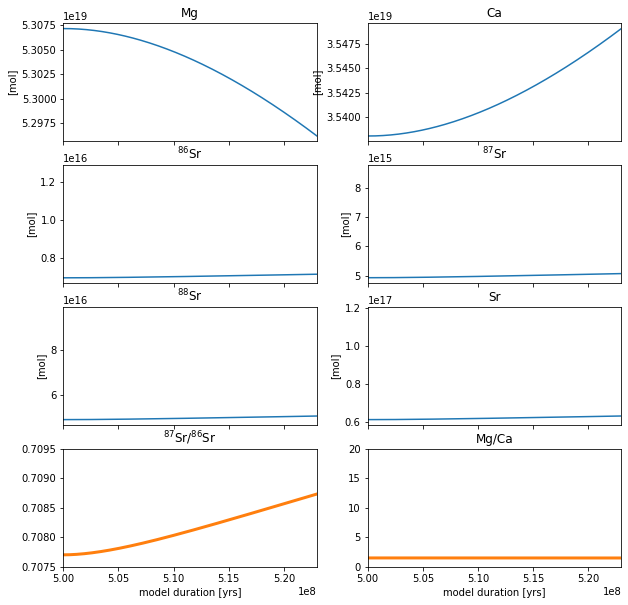

In [27]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.7075,0.7095,0,20,500e6,T_ss+T_stage1)

#### Stage 2 

In [28]:
# model duration
T_stage2 = stage2_age + 0
axvlines.append(axvlines[0]-(T_stage1/1e6))

ind_vars_4 = ind_vars_3.copy()
ind_vars_4['W_X_cc'] = ind_vars_3['W_X_cc'] * 0.95
ind_vars_4['W_X_juv'] = (total_W_MgCa_sil-ind_vars_4['W_X_cc']*(ind_vars_4['conc_Mg_cc']+ind_vars_4['conc_Ca_cc']))/\
                        (ind_vars_4['conc_Mg_juv']+ind_vars_4['conc_Ca_juv'])
ind_vars_4_df = dict_to_sorted_df(ind_vars_4)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model(dt,T_stage2,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_3_df,ind_vars_4_df)

W_X_cc changing from 730736842105263.2 to 694200000000000.0
W_X_juv changing from 919751733115717.4 to 930929170288885.4


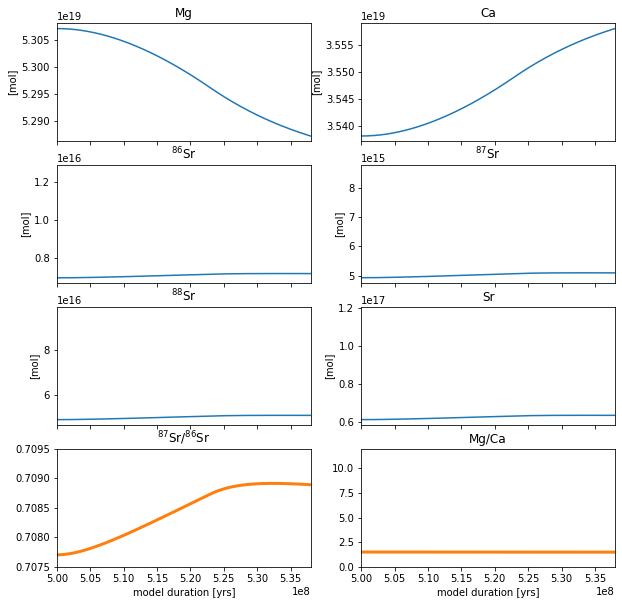

In [29]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.7075,0.7095,0,12,500e6,T_ss+T_stage1+T_stage2)

#### Evaluate

In [30]:
(W_Sr_cc, W_Sr_juv, W_Sr_carb1, W_Sr_carb2, H_Sr_basalt, k) = get_Sr_fluxes(ind_vars_2, ind_vars_3, ind_vars_4,
                                                                            Mg, T_ss, T_stage1, T_stage2, dt)
W_Sr_carb = W_Sr_carb1 + W_Sr_carb2

total_Sr_flux = W_Sr_cc + W_Sr_juv + W_Sr_carb + H_Sr_basalt

# shift the time vector, and convert it into Ma
t = t * -1
t = t + t_start
t = t / 1e6

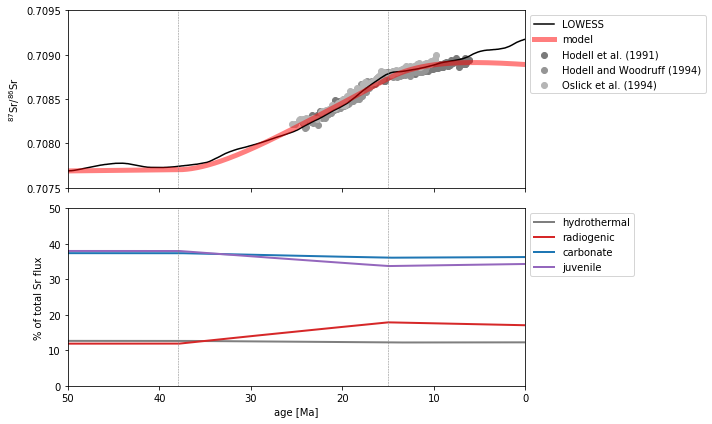

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr isotopes
Sr_cmap = get_cmap('Greys')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.6)], label='Hodell et al. (1991)')
ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.5)], label='Hodell and Woodruff (1994)')
ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax[0].plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')

ax[0].plot(t, Sr87/Sr86, c='red', lw=5, alpha=0.5, label='model')

# Sr fluxes
ax[1].plot(t, H_Sr_basalt/total_Sr_flux*100,
           label='hydrothermal', c='C7', lw=2)
ax[1].plot(t, W_Sr_cc/total_Sr_flux*100,
           label='radiogenic', c='C3', lw=2)
ax[1].plot(t, W_Sr_carb/total_Sr_flux*100,
           label='carbonate', c='C0', lw=2)
ax[1].plot(t, W_Sr_juv/total_Sr_flux*100,
           label='juvenile', c='C4', lw=2)

# the axvlines
for i in range(len(axvlines)):
    ax[0].axvline(axvlines[i], c='C7', ls='--', lw=0.5)
    ax[1].axvline(axvlines[i], c='C7', ls='--', lw=0.5)
    
ax[0].set_xlim(50,0)
ax[0].set_ylim(0.7075,0.7095)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend(loc='upper left', bbox_to_anchor=(1,1))

ax[1].set_ylim(0,50)
ax[1].set_ylabel('% of total Sr flux')
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[1].set_xlabel('age [Ma]')

fig.tight_layout()
plt.show(fig)

### Scenario 2

#### Set Up

In [32]:
ind_vars_1 = {'W_X_carb1':6.0e14,                     #kg/yr
              'W_X_carb2':0.0,                     #kg/yr
              'W_X_cc':8.0e14,                       #kg/yr - this value gets set during spin up
              'W_X_juv':9.0e14,                      #kg/yr
              'conc_Mg_cc':12800 / 1e6 / 24.305,    #ppm to mol/kg
              'conc_Ca_cc':23750 / 1e6 / 40.078,    #ppm to mol/kg
              'conc_Sr_cc':310 / 1e6 / 87.62,       #ppm to mol/kg
              'conc_Mg_juv':45500 / 1e6 / 24.305,   #ppm to mol/kg
              'conc_Ca_juv':71600 / 1e6 / 40.078,   #ppm to mol/kg
              'conc_Sr_juv':465 / 1e6 / 87.62,      #ppm to mol/kg
              'conc_Mg_carb1':47000 / 1e6 / 24.305,  #ppm to mol/kg
              'conc_Ca_carb1':302300 / 1e6 / 40.078, #ppm to mol/kg
              'conc_Sr_carb1':610 / 1e6 / 87.62,     #ppm to mol/kg
              'conc_Mg_carb2':47000 / 1e6 / 24.305,  #ppm to mol/kg
              'conc_Ca_carb2':302300 / 1e6 / 40.078, #ppm to mol/kg
              'conc_Sr_carb2':610 / 1e6 / 87.62,     #ppm to mol/kg
              'alpha_MgCa':1,
              'alpha_SrCa':0.0010,
              'k':4.5e13,                             #kg(H2O)/yr
              'P_Mg_carb':1.8e12,                      #mol/yr
              'K_Sr':0.85,
              'W_87Sr86Sr_juv':0.7035,
              'W_87Sr86Sr_carb1':0.7080,
              'W_87Sr86Sr_carb2':0.7250,
              'H_87Sr86Sr_basalt':0.7030,
              'r_86Sr88Sr':0.1194,
              'Msw':1.35e21}                           #kg

In [33]:
stage1_age = 38e6
stage2_age = 15e6
t_start = stage1_age + 500e6

Get initial parameters:

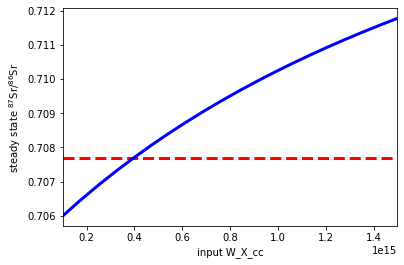

Mg_0 =    3.758934159096568e+19
Ca_0 =    2.5059561060643787e+19
W_X_cc =  394736842105263.2
###
Desired ratio was: 0.7077
Obtained ratio is: 0.7076832796780796
Difference is:     1.6720321920349335e-05
###
W_Sr_cc     = 12.04%
W_Sr_juv    = 41.16%
W_Sr_carb   = 36.00%
H_Sr_basalt = 10.80%


In [34]:
mm_Sr = 87.62 #molar mass of Sr
Sr_0 = 87.40 * 1e-6 * ind_vars_1['Msw']

(Mg_0,Ca_0,W_X_cc) = get_initial_parameters(1.5,0.7077,Sr_0,
                                            ind_vars_1['W_X_carb1'],ind_vars_1['W_X_carb2'],ind_vars_1['W_X_juv'],\
                                            1e14,15e14,t_start,ind_vars_1,20)

* radiogenic lithologies = ∼25%
* juvenile lithologies = ∼30%
* carbonate = ∼35%
* hydrothermal = ∼10%

Use the initial parameters and run to steady state:

In [35]:
dt = 0.1e6
T_ss = 500e6

ind_vars_2 = ind_vars_1.copy()
ind_vars_2['W_X_cc'] = W_X_cc
ind_vars_2_df = dict_to_sorted_df(ind_vars_2)

Sr88_0 = 0.82 * Sr_0 #approximate ratios
Sr87_0 = 0.073 * Sr_0
Sr86_0 = 0.107 * Sr_0

t = np.array([0])
Mg = np.array([Mg_0])
Ca = np.array([Ca_0])
Sr88 = np.array([Sr88_0])
Sr87 = np.array([Sr87_0])
Sr86 = np.array([Sr86_0])

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model(dt,T_ss,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_2_df)

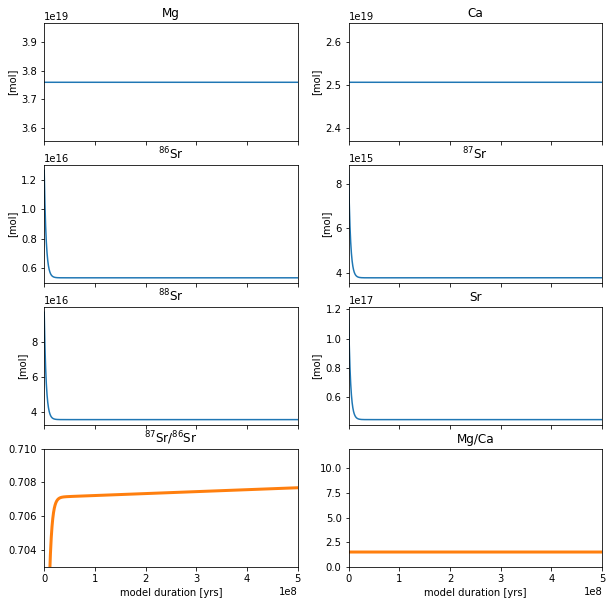

In [36]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.703,0.710,0,12,0,T_ss)

Check some characteristics of the model:

In [37]:
# Sr residence time
W_Sr_cc_i = ind_vars_2['W_X_cc']*ind_vars_2['conc_Sr_cc']
W_Sr_juv_i = ind_vars_2['W_X_juv']*ind_vars_2['conc_Sr_juv']
W_Sr_carb1_i = ind_vars_2['W_X_carb1']*ind_vars_2['conc_Sr_carb1']
W_Sr_carb2_i = ind_vars_2['W_X_carb2']*ind_vars_2['conc_Sr_carb2']
W_Sr_carb_i = W_Sr_carb1_i + W_Sr_carb2_i
H_Sr_basalt_i = ind_vars_2['alpha_SrCa']*((ind_vars_2['k']*(Mg[-1]/ind_vars_2['Msw']))/ind_vars_2['alpha_MgCa'])
total_Sr_flux_i = W_Sr_cc_i + W_Sr_juv_i + W_Sr_carb_i + H_Sr_basalt_i

print('Sr residence time = {:.2f} m.y.'.format((Sr88[-1]+Sr87[-1]+Sr86[-1])/total_Sr_flux_i/1e6))

Sr residence time = 3.87 m.y.


* ~3-5 m.y.

In [38]:
# concentrations of Mg, Ca, Sr
Mg_i_mM = Mg[-1]/ind_vars_1['Msw']*1e3
Ca_i_mM = Ca[-1]/ind_vars_1['Msw']*1e3
Sr_i_uM = (Sr88[-1]+Sr87[-1]+Sr86[-1])/ind_vars_1['Msw']*1e6

print('Mg = {:.2f} mM'.format(Mg_i_mM))
print('Ca = {:.2f} mM'.format(Ca_i_mM))
print('Sr = {:.2f} uM'.format(Sr_i_uM))

Mg = 27.84 mM
Ca = 18.56 mM
Sr = 33.25 uM


* Mg = 36 mM
* Ca = 24 mM
* Sr = 87.40 uM

#### Stage 1

In [39]:
# model duration
T_stage1 = stage1_age - stage2_age
axvlines = [(t_start-T_ss)/(1e6)]

total_W_MgCa_sil = ind_vars_2['W_X_cc']*(ind_vars_2['conc_Mg_cc']+ind_vars_2['conc_Ca_cc']) +\
                   ind_vars_2['W_X_juv']*(ind_vars_2['conc_Mg_juv']+ind_vars_2['conc_Ca_juv'])

ind_vars_3 = ind_vars_2.copy()
ind_vars_3['W_X_cc'] = ind_vars_2['W_X_cc'] * 1.55
ind_vars_3['W_X_carb1'] = ind_vars_2['W_X_carb1']
ind_vars_3['W_X_carb2'] = ind_vars_2['W_X_carb2']
ind_vars_3['W_87Sr86Sr_carb1'] = ind_vars_2['W_87Sr86Sr_carb1']
ind_vars_3['W_87Sr86Sr_carb2'] = ind_vars_2['W_87Sr86Sr_carb2']
ind_vars_3['W_X_juv'] = (total_W_MgCa_sil-ind_vars_3['W_X_cc']*(ind_vars_3['conc_Mg_cc']+ind_vars_3['conc_Ca_cc']))/\
                        (ind_vars_3['conc_Mg_juv']+ind_vars_3['conc_Ca_juv'])
ind_vars_3_df = dict_to_sorted_df(ind_vars_3)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model(dt,T_stage1,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_2_df,ind_vars_3_df)

W_X_cc changing from 394736842105263.2 to 611842105263158.0
W_X_juv changing from 900000000000000.0 to 833582644282169.8


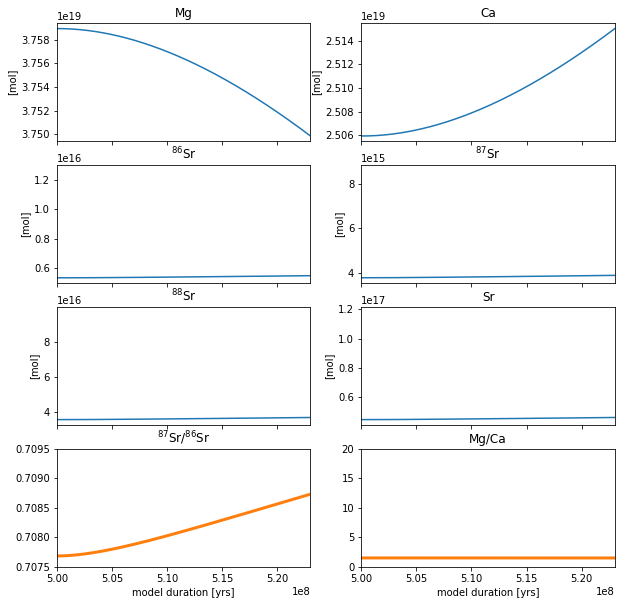

In [40]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.7075,0.7095,0,20,500e6,T_ss+T_stage1)

#### Stage 2 

In [41]:
# model duration
T_stage2 = stage2_age + 0
axvlines.append(axvlines[0]-(T_stage1/1e6))

ind_vars_4 = ind_vars_3.copy()
ind_vars_4['W_X_cc'] = ind_vars_3['W_X_cc'] * 0.95
ind_vars_4['W_X_carb1'] = ind_vars_3['W_X_carb1']
ind_vars_4['W_X_carb2'] = ind_vars_3['W_X_carb2'] + 4e13
ind_vars_4['W_87Sr86Sr_carb1'] = ind_vars_3['W_87Sr86Sr_carb1']
ind_vars_4['W_87Sr86Sr_carb2'] = ind_vars_3['W_87Sr86Sr_carb2']
ind_vars_4['W_X_juv'] = (total_W_MgCa_sil-ind_vars_4['W_X_cc']*(ind_vars_4['conc_Mg_cc']+ind_vars_4['conc_Ca_cc']))/\
                        (ind_vars_4['conc_Mg_juv']+ind_vars_4['conc_Ca_juv'])
ind_vars_4_df = dict_to_sorted_df(ind_vars_4)

(t,Mg,Ca,Sr88,Sr87,Sr86) = seawater_model(dt,T_stage2,t,Mg,Ca,Sr88,Sr87,Sr86,t_start,ind_vars_3_df,ind_vars_4_df)

W_X_carb2 changing from 0.0 to 40000000000000.0
W_X_cc changing from 611842105263158.0 to 581250000000000.1
W_X_juv changing from 833582644282169.8 to 842941453496955.0


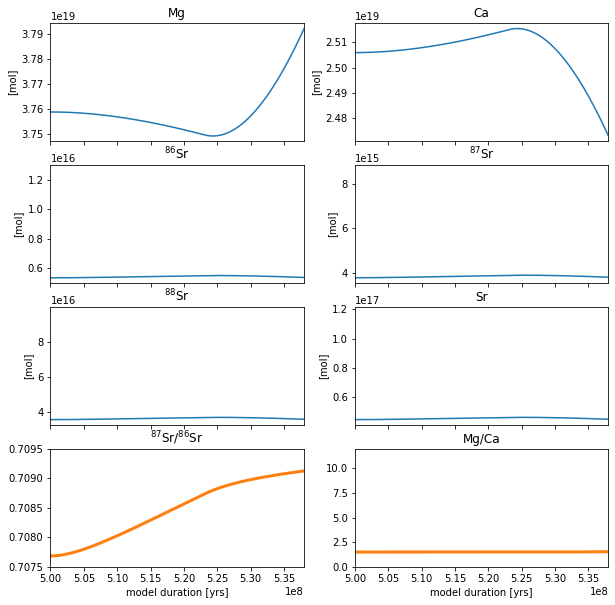

In [42]:
fig, ax = plot_seawater_model(t,Mg,Ca,Sr88,Sr87,Sr86,0.7075,0.7095,0,12,500e6,T_ss+T_stage1+T_stage2)

#### Evaluate

In [43]:
(W_Sr_cc, W_Sr_juv, W_Sr_carb1, W_Sr_carb2, H_Sr_basalt, k) = get_Sr_fluxes(ind_vars_2, ind_vars_3, ind_vars_4,
                                                                            Mg, T_ss, T_stage1, T_stage2, dt)
W_Sr_carb = W_Sr_carb1 + W_Sr_carb2

total_Sr_flux = W_Sr_cc + W_Sr_juv + W_Sr_carb + H_Sr_basalt

# shift the time vector, and convert it into Ma
t = t * -1
t = t + t_start
t = t / 1e6

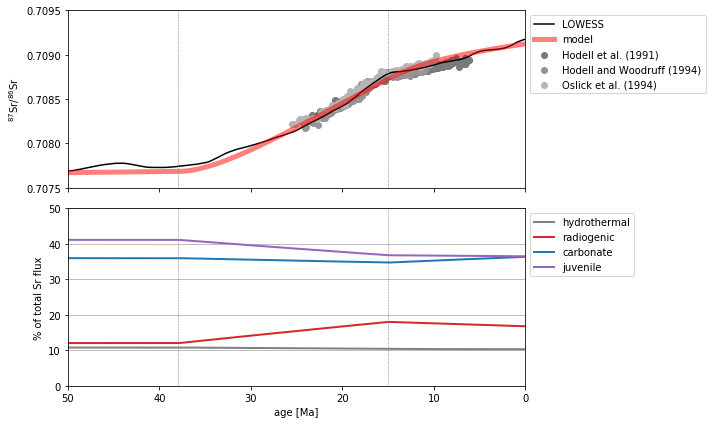

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr isotopes
Sr_cmap = get_cmap('Greys')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.6)], label='Hodell et al. (1991)')
ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.5)], label='Hodell and Woodruff (1994)')
ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax[0].plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')

ax[0].plot(t, Sr87/Sr86, c='red', lw=5, alpha=0.5, label='model')

# Sr fluxes
ax[1].plot(t, H_Sr_basalt/total_Sr_flux*100,
           label='hydrothermal', c='C7', lw=2)
ax[1].plot(t, W_Sr_cc/total_Sr_flux*100,
           label='radiogenic', c='C3', lw=2)
ax[1].plot(t, W_Sr_carb/total_Sr_flux*100,
           label='carbonate', c='C0', lw=2)
ax[1].plot(t, W_Sr_juv/total_Sr_flux*100,
           label='juvenile', c='C4', lw=2)

# the axvlines
for i in range(len(axvlines)):
    ax[0].axvline(axvlines[i], c='C7', ls='--', lw=0.5)
    ax[1].axvline(axvlines[i], c='C7', ls='--', lw=0.5)
    
ax[0].set_xlim(50,0)
ax[0].set_ylim(0.7075,0.7095)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend(loc='upper left', bbox_to_anchor=(1,1))

ax[1].set_ylim(0,50)
ax[1].set_ylabel('% of total Sr flux')
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[1].set_xlabel('age [Ma]')
ax[1].yaxis.grid()

fig.tight_layout()
plt.show(fig)

In [45]:
carb2_frac = (ind_vars_4['W_X_carb2']/(ind_vars_4['W_X_carb1']+ind_vars_4['W_X_carb2']))*100
print('carb2 fraction of total carb = {:.2f}%'.format(carb2_frac))

carb2 fraction of total carb = 6.25%
